* Name: Lex C. Crist
* NetID: acc297
* Course: BTRY 4381, Fall 2022
* Professor: Dr. Haiyuan Yu
* TA: Yilin Liu

# Importing necessary modules

In [2]:
import os
import sys
import copy
import traceback
import math
import scipy.stats
import re
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn import tree
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Problem 1 - Protein Secondary Structure Prediction

In this problem, machine learning will be used to train a binary classifier using features from protein sequences to determine whether or not the residue is alpha-helix using features, training and testing sets defined from `Expasy_AA_Scales.txt`, `UniProt2Seq.txt` and `samples.txt`. 

## Loading the Files in:

Each of the `.txt` files are loaded into `DataFrames` using `pandas`. 

In [4]:
expasy = pd.read_csv("/content/Expasy_AA_Scales.txt", sep = "\t")

In [5]:
not_scaled = ["AA"]
scaled = []
for col in expasy.columns.to_list():
  if col not in not_scaled:
    scaled.append(col)
# The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. 
# The names can be anything you like (unique and don’t contain double underscores “__”). 

num_pipeline = Pipeline([
    # handling missing values
    ('imputer', SimpleImputer(strategy="median")),
    # feature scaling
    ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, scaled)
    ])

expasy_prepared = full_pipeline.fit_transform(expasy)

In [6]:
uniprot = pd.read_csv("/content/UniProt2Seq.txt", sep = "\t")

In [7]:
samples = pd.read_csv("/content/samples.txt", sep = "\t")

The information from the three `DataFrames` are combined into one based on the `UniProt IDs` in `samples.txt`:

In [8]:
dfs_list = []
AA_groups = uniprot.groupby("UniProt")
bool_groups = samples.groupby("UniProt")
for prot in samples["UniProt"].unique():
  df1 = AA_groups.get_group(prot)
  df2 = bool_groups.get_group(prot)
  data_df = pd.DataFrame()
  data_df["UniProt"] = list(df2["UniProt"])
  data_df["AA"] = list(df1["AA"])
  data_df["Position"] = list(df2["Position"])
  data_df["is_alpha_helix"] = list(df2["is_alpha_helix"])
  dfs_list.append(data_df)
comb_data = pd.concat(dfs_list)
comb_data.index = [x for x in range(0,len(comb_data["UniProt"]))]

In [9]:
keylist = expasy.columns.to_list()
keylist.pop(keylist.index("AA"))
feature_group = expasy.groupby("AA")
combo_group = comb_data.groupby("AA")
aa_dfs = []
for aminoacid in expasy["AA"]:
  aa_info = feature_group.get_group(aminoacid)
  aa_df = combo_group.get_group(aminoacid)
  for col in keylist:
    aa_df[col] = [float(aa_info[col])]*len(aa_df["UniProt"])
  aa_dfs.append(aa_df)
all_data = pd.concat(aa_dfs)

<ipython-input-9-e5b848aaa74e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_df[col] = [float(aa_info[col])]*len(aa_df["UniProt"])


The combined DataFrame is displayed below:

In [10]:
all_data.sort_index()

,UniProt,AA,Position,is_alpha_helix,Coil_Deleage_Roux,beta_sheet_Deleage_Roux,HPLC_retention_pH74,beta_sheet_Levitt,Hphob_Wolfenden,beta_turn_Deleage_Roux,...,Hphob_HPLC_Wilson,Hphob_HPLC_Parker,Hphob_Tanford,buried_residues,Recognition_factors,Hphob_Rose,Parallel_beta_strand,accessible_residues,Hphob_Kyte_Doolittle,Hphob_Rf_mobility
0,A6X980,M,1,0,0.810,1.210,4.8,0.97,-1.48,0.436,...,2.5,-4.2,0.64,1.9,80.0,0.85,1.49,1.0,1.9,8.7
1,A6X980,S,2,0,1.130,0.928,1.2,0.95,-5.06,1.316,...,-0.6,6.5,-0.18,8.0,107.0,0.66,0.70,9.4,-0.8,3.1
2,A6X980,S,3,0,1.130,0.928,1.2,0.95,-5.06,1.316,...,-0.6,6.5,-0.18,8.0,107.0,0.66,0.70,9.4,-0.8,3.1
3,A6X980,N,4,0,1.167,0.604,0.8,0.76,-9.68,1.572,...,-0.2,7.0,-0.78,2.9,94.0,0.63,0.54,6.7,-3.5,0.6
4,A6X980,S,5,0,1.130,0.928,1.2,0.95,-5.06,1.316,...,-0.6,6.5,-0.18,8.0,107.0,0.66,0.70,9.4,-0.8,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57362,T0D7A2,N,1125,0,1.167,0.604,0.8,0.76,-9.68,1.572,...,-0.2,7.0,-0.78,2.9,94.0,0.63,0.54,6.7,-3.5,0.6
57363,T0D7A2,T,1126,0,1.148,1.221,2.7,1.21,-4.88,0.739,...,-2.2,5.2,-0.05,4.9,93.0,0.70,0.59,7.0,-0.7,3.5
57364,T0D7A2,G,1127,0,1.251,0.657,0.0,0.92,2.39,1.860,...,1.2,5.7,0.48,11.8,84.0,0.72,0.79,6.7,-0.4,4.1
57365,T0D7A2,D,1128,0,1.197,0.541,-8.2,0.72,-10.95,1.197,...,-1.4,10.0,-0.09,2.9,81.0,0.62,0.50,7.7,-3.5,0.7


# Data Exploratory Analysis

First, the local neighborhood of each of the residues is taken into account for each of the expasy information columns by creating a series from `series.rolling` using a window size of 9 (meaning pos-4, pos-3, ..., pos, ..., pos+4). In addition, this is done within the proteins by splitting up the data by the proteins since the end of one protein should not affect the start of the next. With this division, a column is added that determines the relative location of the amino acids. 

In [11]:
prot_groups = all_data.groupby("UniProt")
rolling_prots = []
for prot in all_data["UniProt"].unique():
  all_data_part = prot_groups.get_group(prot)
  prot_df = pd.DataFrame()
  col_list = all_data.columns.to_list()
  col_list_rolling = col_list[4:]
  col_list_static = col_list[:4]
  for key in col_list_static:
    prot_df[key] = copy.copy(all_data_part[key])
  for key in col_list_rolling:
    prot_df[key] = all_data_part[key].rolling(10, min_periods = 1).mean()
  len_protein = len(prot_df["Position"])
  prot_df["Relative Position"] = prot_df["Position"] / len_protein
  prot_df["mean_alpha_helix"] = all_data_part['is_alpha_helix'].rolling(10, min_periods = 1).mean()
  rolling_prots.append(prot_df)
rolling_df = pd.concat(rolling_prots)

In [12]:
raw_corr = rolling_df.corr()

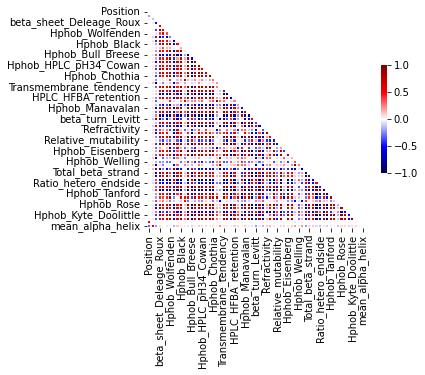

In [13]:
mask = np.zeros_like(raw_corr, dtype=bool)
mask[np.triu_indices_from(mask, k=0)] = True 
sns.heatmap(raw_corr, mask=mask, cmap='seismic', vmax=1, vmin=-1, center=0, square=True,
            linewidth=.5, cbar_kws={'shrink': .5})

In [14]:
raw_corr['mean_alpha_helix'].sort_values(ascending = False)

mean_alpha_helix            1.000000
is_alpha_helix              0.572014
alpha_helix_Deleage_Roux    0.218862
alpha_helix_Chou_Fasman     0.214106
alpha_helix_Levitt          0.204014
                              ...   
beta_turn_Deleage_Roux     -0.161897
beta_turn_Levitt           -0.192890
beta_turn_Chou_Fasman      -0.197682
Coil_Deleage_Roux          -0.208297
Position                   -0.298020
Name: mean_alpha_helix, Length: 61, dtype: float64

In [20]:
feature_df = pd.DataFrame()
feature_df["UniProt"] = copy.copy(rolling_df['UniProt'])
feature_df["AA"] =  copy.copy(rolling_df['AA'])
feature_df["is_alpha_helix"] = copy.copy(rolling_df["is_alpha_helix"])
feature_df['mean_alpha_helix'] = copy.copy(rolling_df['mean_alpha_helix'])
feature_df["Position"] = copy.copy(rolling_df["Position"])
feature_df["Relative Position"] = copy.copy(rolling_df["Relative Position"])

In [22]:
col_list = expasy.columns.to_list()
col_list.pop(0)
col_list.append("Relative Position")
for i in range(len(col_list)):
  key1 = col_list[i]
  non = rolling_df[key1]
  sqrt = np.sqrt(rolling_df[key1])
  log = np.log(rolling_df[key1])
  selfs = {key1: non, "Op_Sqrt " + key1: sqrt, "Op_Log " + key1: log}
  corrs_self = {}
  for key in selfs:
    corrs_val = abs(rolling_df["mean_alpha_helix"].corr(selfs[key]))
    corrs_self[corrs_val] = key
  max_self = max([float(x) for x in list(corrs_self.keys())])
  if max_self > 0.225:
    feature_df[corrs_self[max_self]] = selfs[corrs_self[max_self]]
  l = i+1
  while l < len(col_list):
    key2 = col_list[l]
    avg = (rolling_df[key1]+rolling_df[key2])/2
    div1 = (rolling_df[key1]/rolling_df[key2])
    div2 = (rolling_df[key2]/rolling_df[key1])
    prod = (rolling_df[key1]*rolling_df[key2])
    btwns = {"Average": avg, "Div1": div1, "Div2": div2, "Prod": prod}
    col_keys = {"Average": key1 + " op& " + key2, "Div1": key1 + " op/ " + key2, \
                 "Div2": key2 + " op/ " + key1, "Prod": key1 + " op* " + key2}
    corrs_dict = {}
    for key in btwns:
      corr_val = abs(rolling_df["mean_alpha_helix"].corr(btwns[key]))
      corrs_dict[corr_val] = key
    max_btwns = max([float(x) for x in list(corrs_dict.keys())])
    if max_btwns > 0.225:
      feature_df[col_keys[corrs_dict[max_btwns]]] = btwns[corrs_dict[max_btwns]]
    l += 1

KeyboardInterrupt: ignored

In [16]:
feature_df.sort_index()

,UniProt,AA,is_alpha_helix,mean_alpha_helix,Position,Relative Position,Coil_Deleage_Roux op/ alpha_helix_Chou_Fasman,Op_Log alpha_helix_Deleage_Roux,alpha_helix_Deleage_Roux op* Hphob_Manavalan,Average_flexibility op/ alpha_helix_Deleage_Roux,beta_turn_Chou_Fasman op/ alpha_helix_Deleage_Roux,Recognition_factors op/ alpha_helix_Deleage_Roux,alpha_helix_Deleage_Roux op& Hphob_Rose,Average_flexibility op/ alpha_helix_Chou_Fasman,Recognition_factors op/ alpha_helix_Chou_Fasman
0,A6X980,M,0,0.0,1,0.008333,0.843282,0.070272,14.619046,0.376585,0.685123,79.977629,0.92390,0.364292,77.366997
1,A6X980,S,0,0.0,2,0.016667,2.540678,-0.660293,5.867645,0.987033,2.924327,179.214244,0.57935,0.864407,156.949153
2,A6X980,S,0,0.0,3,0.025000,2.390164,-0.613597,6.140559,0.942002,2.774289,173.993351,0.59270,0.836066,154.426230
3,A6X980,N,0,0.0,4,0.033333,0.731574,0.173617,17.311059,0.318594,0.577505,72.209146,1.00880,0.327855,74.307958
4,A6X980,S,0,0.0,5,0.041667,2.249206,-0.568985,6.412781,0.900901,2.637343,169.228052,0.60605,0.809524,152.063492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57362,T0D7A2,N,0,0.5,1125,0.996457,1.741791,-0.258771,8.816240,0.595855,2.020725,121.761658,0.70100,0.686567,140.298507
57363,T0D7A2,T,0,0.1,1126,0.997343,1.383133,-0.242072,9.176650,0.560510,1.222930,118.471338,0.74250,0.530120,112.048193
57364,T0D7A2,G,0,0.3,1127,0.998229,2.194737,-0.673345,6.339300,1.058824,3.058824,164.705882,0.61500,0.947368,147.368421
57365,T0D7A2,D,0,0.3,1128,0.999114,1.185149,-0.079043,10.025400,0.551948,1.580087,87.662338,0.77200,0.504950,80.198020


In [17]:
feature_corr = feature_df.corr()

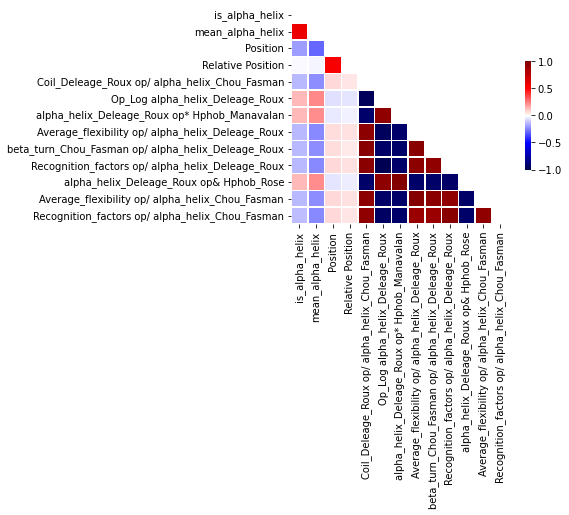

In [18]:
mask = np.zeros_like(feature_corr, dtype=bool)
mask[np.triu_indices_from(mask, k=0)] = True 
sns.heatmap(feature_corr, mask=mask, cmap='seismic', vmax=1, vmin=-1, center=0, square=True,
            linewidth=.5, cbar_kws={'shrink': .5})

In [19]:
feature_corr["mean_alpha_helix"].sort_values(ascending = False)

mean_alpha_helix                                      1.000000
is_alpha_helix                                        0.572014
Op_Log alpha_helix_Deleage_Roux                       0.227101
alpha_helix_Deleage_Roux op* Hphob_Manavalan          0.225569
alpha_helix_Deleage_Roux op& Hphob_Rose               0.225452
Relative Position                                    -0.023207
Coil_Deleage_Roux op/ alpha_helix_Chou_Fasman        -0.225444
Average_flexibility op/ alpha_helix_Chou_Fasman      -0.225524
beta_turn_Chou_Fasman op/ alpha_helix_Deleage_Roux   -0.226229
Average_flexibility op/ alpha_helix_Deleage_Roux     -0.226732
Recognition_factors op/ alpha_helix_Chou_Fasman      -0.227998
Recognition_factors op/ alpha_helix_Deleage_Roux     -0.233273
Position                                             -0.298020
Name: mean_alpha_helix, dtype: float64

In [18]:
feature_df = feature_df.drop("mean_alpha_helix", axis =1)
feature_df.sort_index()

,UniProt,AA,is_alpha_helix,Position,Relative Position,Coil_Deleage_Roux op/ alpha_helix_Chou_Fasman,Op_Log alpha_helix_Deleage_Roux,alpha_helix_Deleage_Roux op* Hphob_Manavalan,Average_flexibility op/ alpha_helix_Deleage_Roux,beta_turn_Chou_Fasman op/ alpha_helix_Deleage_Roux,Recognition_factors op/ alpha_helix_Deleage_Roux,alpha_helix_Deleage_Roux op& Hphob_Rose,Average_flexibility op/ alpha_helix_Chou_Fasman,Recognition_factors op/ alpha_helix_Chou_Fasman
0,A6X980,M,0,1,0.008333,0.843282,0.070272,14.619046,0.376585,0.685123,79.977629,0.92390,0.364292,77.366997
1,A6X980,S,0,2,0.016667,2.540678,-0.660293,5.867645,0.987033,2.924327,179.214244,0.57935,0.864407,156.949153
2,A6X980,S,0,3,0.025000,2.390164,-0.613597,6.140559,0.942002,2.774289,173.993351,0.59270,0.836066,154.426230
3,A6X980,N,0,4,0.033333,0.731574,0.173617,17.311059,0.318594,0.577505,72.209146,1.00880,0.327855,74.307958
4,A6X980,S,0,5,0.041667,2.249206,-0.568985,6.412781,0.900901,2.637343,169.228052,0.60605,0.809524,152.063492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57362,T0D7A2,N,0,1125,0.996457,1.741791,-0.258771,8.816240,0.595855,2.020725,121.761658,0.70100,0.686567,140.298507
57363,T0D7A2,T,0,1126,0.997343,1.383133,-0.242072,9.176650,0.560510,1.222930,118.471338,0.74250,0.530120,112.048193
57364,T0D7A2,G,0,1127,0.998229,2.194737,-0.673345,6.339300,1.058824,3.058824,164.705882,0.61500,0.947368,147.368421
57365,T0D7A2,D,0,1128,0.999114,1.185149,-0.079043,10.025400,0.551948,1.580087,87.662338,0.77200,0.504950,80.198020


In [20]:
prepared_df = pd.DataFrame()
for col in not_scaled:
  prepared_df[col] = feature_df[col]
for i in range(len(scaled)):
  key = scaled[i]
  prepared_df[key] = feature_prepared[:,i]

# Model Selection and Hyperparameter Tuning

## Train/Test Split

The data for the model is separated into training and testing groups with a random 80/20 split. 

In [21]:
train, test, trainlabels, testlabels = train_test_split(
    # Data set to be split: lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
    feature_prepared, prepared_df['is_alpha_helix'],
    test_size=0.2,   # either the proportion (decimal) of the test set or exact sample size (integer)
    random_state=0)  # a random seed (integer) for reproducible output across multiple function calls

print('Training samples: {}'.format(train.shape[0]))
print('Testing samples: {}'.format(test.shape[0]))

Training samples: 45893
Testing samples: 11474


## Selecting a Model

There are three different models that can be used to try to predict the alpha-helixcal structures based on the amino acid sequence of a protein. A k-fold cross validation is used to choose one since the accuracy of the model may not be a . 

In [22]:
def cross_validation(reg, X, y):
    scores = cross_val_score(
         reg, X, y,  # estimator: the object to use to fit the data.
         # scoring: A str or a scorer callable object / function with signature
         scoring = "neg_root_mean_squared_error", 
         cv = 5)  # 5-fold cross validation
    return scores

### Decision Tree Model

In [23]:
tree_class = tree.DecisionTreeClassifier(random_state = 0, min_samples_leaf = 10)
tree_class.fit(train, trainlabels)

DecisionTreeClassifier(min_samples_leaf=10, random_state=0)

In [24]:
tree_prediction = tree_class.predict(test)
tree_pred_train = tree_class.predict(train)

In [25]:
print ("Decision Tree")
print ("Training accuracy", np.mean(tree_pred_train == trainlabels))
print ("Testing accuracy", np.mean(tree_prediction == testlabels))

Decision Tree
Training accuracy 0.8449654631425272
Testing accuracy 0.755621404915461


In [26]:
rf_rmse_scores = cross_validation(tree_class, train, trainlabels)
print("Scores: {}".format(rf_rmse_scores))
print("Mean: {}".format(round(rf_rmse_scores.mean(), 3)))
print("Standard Deviation: {}".format(round(rf_rmse_scores.std(), 3)))

Scores: [-0.50630624 -0.49904583 -0.50176722 -0.50525674 -0.49776139]
Mean: -0.502
Standard Deviation: 0.003


In [27]:
rf_rmse_scores = cross_validation(tree_class, test, testlabels)
print("Scores: {}".format(rf_rmse_scores))
print("Mean: {}".format(round(rf_rmse_scores.mean(), 3)))
print("Standard Deviation: {}".format(round(rf_rmse_scores.std(), 3)))

Scores: [-0.51301153 -0.52972637 -0.50228237 -0.51470744 -0.51142143]
Mean: -0.514
Standard Deviation: 0.009


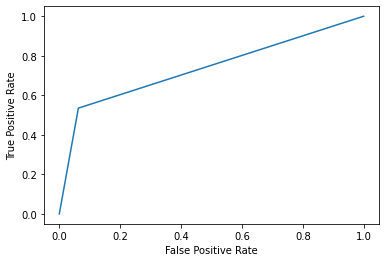

In [28]:
fpr, tpr, _ = metrics.roc_curve(trainlabels, tree_pred_train)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

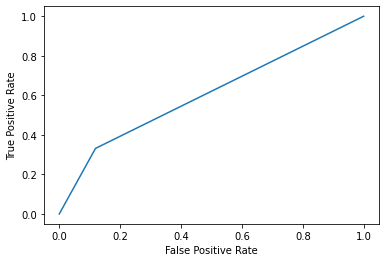

In [29]:
fpr, tpr, _ = metrics.roc_curve(testlabels, tree_prediction)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [30]:
tree_class.get_depth()

31

In [31]:
np.unique(tree_class.predict(test))

array([0, 1])

### Forest Classifier Model

In [32]:
train, test, trainlabels, testlabels = train_test_split(
    # Data set to be split: lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
    feature_prepared, feature_df['is_alpha_helix'],
    test_size=0.2,   # either the proportion (decimal) of the test set or exact sample size (integer)
    random_state=0)  # a random seed (integer) for reproducible output across multiple function calls

print('Training samples: {}'.format(train.shape[0]))
print('Testing samples: {}'.format(test.shape[0]))

Training samples: 45893
Testing samples: 11474


In [33]:
forest_class = RandomForestClassifier(random_state = 123, verbose=1, min_samples_leaf = 3)
forest_class.fit(train, trainlabels)
forest_prediction = forest_class.predict(test)
forest_pred_train = forest_class.predict(train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


In [34]:
forest_class.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 1,
 'warm_start': False}

In [35]:
print ("Random Forest")
print ("Training accuracy", np.mean(forest_pred_train == trainlabels))
print ("Testing accuracy", np.mean(forest_prediction == testlabels))

Random Forest
Training accuracy 0.8845139781666049
Testing accuracy 0.7700888966358724


In [36]:
rf_rmse_scores = cross_validation(forest_class, train, trainlabels)
print("Scores: {}".format(rf_rmse_scores))
print("Mean: {}".format(round(rf_rmse_scores.mean(), 3)))
print("Standard Deviation: {}".format(round(rf_rmse_scores.std(), 3)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Scores: [-0.4846483  -0.48284663 -0.48069837 -0.48321127 -0.48151718]
Mean: -0.483
Standard Deviation: 0.001


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [37]:
rf_rmse_scores = cross_validation(forest_class, test, testlabels)
print("Scores: {}".format(rf_rmse_scores))
print("Mean: {}".format(round(rf_rmse_scores.mean(), 3)))
print("Standard Deviation: {}".format(round(rf_rmse_scores.std(), 3)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Scores: [-0.49264747 -0.48820511 -0.48417214 -0.50010892 -0.4905382 ]
Mean: -0.491
Standard Deviation: 0.005


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


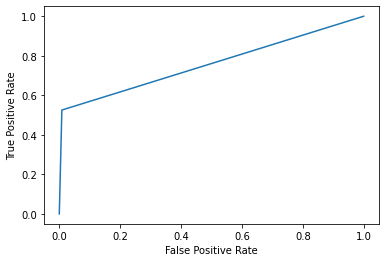

In [38]:
fpr, tpr, _ = metrics.roc_curve(trainlabels, forest_pred_train)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

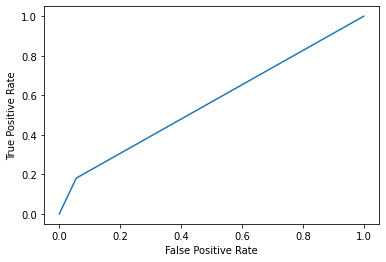

In [39]:
fpr, tpr, _ = metrics.roc_curve(testlabels, forest_prediction)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### SVC Model

In [40]:
svm_class = svm.LinearSVC()
svm_class.fit(train, trainlabels)
svm_prediction = svm_class.predict(test)
svm_pred_train = svm_class.predict(train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
print ("Linear SVC")
print ("Training accuracy", np.mean(svm_pred_train == trainlabels))
print ("Testing accuracy", np.mean(svm_prediction == testlabels))

Linear SVC
Training accuracy 0.7703353452596257
Testing accuracy 0.7717448143629074


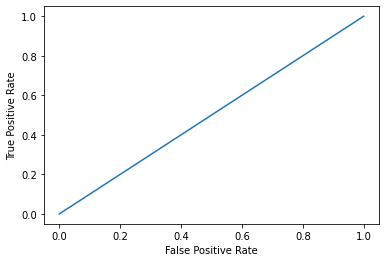

In [42]:
fpr, tpr, _ = metrics.roc_curve(trainlabels, svm_pred_train)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Because of the lack of convergence and the clear overlap of the true and false rates, this model is not used and further evaluation of its accuracy is not considered. 

## Tuning Hyperparameters

Of the three models above, the linearSVC model did not converge and the Forest_Classifier model overfit, so the DecisionTree model is chosen. 

In [43]:
tree_class1 = tree.DecisionTreeClassifier(random_state=0)

In [44]:
tree_param_distribs = {
    'min_samples_leaf' : scipy.stats.randint(low = 8, high = 12),
    'max_depth' : scipy.stats.randint(low = 25, high = 35),
    'max_features' :scipy.stats.randint(low = 3, high = 10),
}

tree_class1 = tree.DecisionTreeClassifier(random_state=0)
tree_search = RandomizedSearchCV(tree_class1, 
    param_distributions=tree_param_distribs,
    n_iter=10, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    random_state=0, verbose=2)  # use verbose parameter to see progress (larger value --> more details)

tree_search.fit(train, trainlabels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..max_depth=30, max_features=3, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=30, max_features=3, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=30, max_features=3, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=30, max_features=3, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=30, max_features=3, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=28, max_features=4, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=28, max_features=4, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=28, max_features=4, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=28, max_features=4, min_samples_leaf=11; total time=   0.1s
[CV] END ..max_depth=28, max_features=4, min_samples_leaf=11; total time=   0.1s
[CV] END ...max_depth=30, max_features=5, min_samples_leaf=8; total time=   0.1s
[CV] END ...max_depth=30, max_features=5, min_sa

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3569a83310>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f35699cfbe0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f35699d12b0>},
                   random_state=0, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [45]:
tree_search.best_params_

{'max_depth': 26, 'max_features': 9, 'min_samples_leaf': 11}

In [46]:
final_model = tree_search.best_estimator_

In [57]:
pred_train1 = final_model.predict(train)
pred_test1 = final_model.predict(test)

# RMSE on test set
print(np.sqrt(mean_squared_error(train[:,0], pred_train1)))
print(np.sqrt(mean_squared_error(test[:,0], pred_test1)))

1.1280433324245487
1.1236442138716067


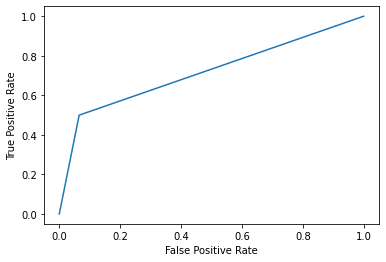

In [48]:
fpr, tpr, _ = metrics.roc_curve(trainlabels, pred_train1)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

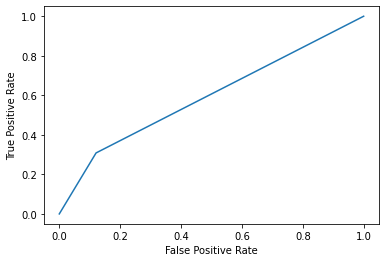

In [49]:
fpr, tpr, _ =metrics.roc_curve(testlabels, pred_test1)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [50]:
predictions = final_model.predict(test)
np.unique(predictions)

array([0, 1])

# Dowloading Files to Use For Website

In [51]:
#joblib.dump(final_model, "./final_model.pkl")

In [52]:
#prepared_df.to_csv('./prepared_df.csv')

In [53]:
prediction_dfs = []

In [54]:
for prot in prepared_df["UniProt"].unique():
  prot_df = prepared_df.groupby("UniProt").get_group(prot)
  prot_df = prot_df.drop("UniProt", axis = 1)
  prot_df = prot_df.drop("AA", axis = 1)
  prot_df = prot_df.drop("is_alpha_helix", axis = 1)
  prot_array = prot_df.to_numpy()
  predictions1 = final_model.predict(prot_array)
  pred_df = pd.DataFrame()
  pred_df["UniProt"] = [prot]*len(predictions1)
  pred_df["Position"] = list(range(1, len(predictions1)+1))
  pred_df["Prediction1"] = predictions1
  prediction_dfs.append(pred_df)

In [55]:
prediction_df = pd.concat(prediction_dfs, ignore_index = True)
prediction_df.sort_index()

,UniProt,Position,Prediction1
0,A8MT69,1,0
1,A8MT69,2,0
2,A8MT69,3,0
3,A8MT69,4,0
4,A8MT69,5,0
...,...,...,...
57362,P60775,79,0
57363,P60775,80,0
57364,P60775,81,0
57365,P60775,82,0


In [56]:
#prediction_df.to_csv('/content/prediction.csv')